https://catalog.data.gov/dataset/3-year-recidivism-for-offenders-released-from-prison

In [79]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))
%matplotlib inline
plt.style.use('ggplot')



In [133]:
# read in dataset
df = pd.read_csv('/Users/matanefron/Downloads/3-Year_Recidivism_for_Offenders_Released_from_Prison.csv')

In [297]:
#Set recidivism to true or false
df['Recidivism'] = df['Recidivism - Return to Prison']=='Yes'
#Change it to binary
df.Recidivism = df.Recidivism.astype(int)


In [298]:
df.dtypes

Offender                                   int64
Recidivism Reporting Year                 object
Race - Ethnicity                          object
Sex                                       object
Age At Release                            object
Convicting Offense Classification         object
Convicting Offense Type                   object
Convicting Offense Subtype                object
Release Type                              object
Main Supervising District                 object
Recidivism - Return to Prison             object
Recidivism Type                           object
Days to Recidivism                       float64
New Conviction Offense Classification     object
New Conviction Offense Type               object
New Conviction Offense Sub Type           object
Part of Target Population                 object
Recidivism                                 int64
Race                                      object
dtype: object

In [136]:
df.describe()


,Offender,Days to Recidivism
count,17060.0,5404.000000
mean,1.0,473.166358
std,0.0,283.185134
min,1.0,0.000000
25%,1.0,241.000000
50%,1.0,418.000000
75%,1.0,687.000000
max,1.0,1095.000000


In [299]:
# number of true in data
print df.groupby(['Race - Ethnicity']).agg({'Recidivism':[np.size]})


                                                Recidivism
                                                      size
Race - Ethnicity                                          
American Indian or Alaska Native - Hispanic             14
American Indian or Alaska Native - Non-Hispanic        318
Asian or Pacific Islander - Hispanic                     2
Asian or Pacific Islander - Non-Hispanic               126
Black -                                                  2
Black - Hispanic                                        26
Black - Non-Hispanic                                  4078
N/A -                                                    4
White -                                                 11
White - Hispanic                                      1030
White - Non-Hispanic                                 11419


In [263]:
#Reduce race categories

def classify_race(x):
    if x == 'White - ' or x=='White - Non-Hispanic':
        return 'white'
    elif x == 'Black - ' or x=='Black - Non-Hispanic' :
        return 'black'
    elif x == 'N/A -' or x=='American Indian or Alaska Native - Non-Hispanic':
        return 'other'
    elif x == 'Asian or Pacific Islander - Non-Hispanic':
        return 'asian'
    else:
        return 'Hispanic'



In [300]:
#Map back 
df['Race'] = df['Race - Ethnicity'].map(classify_race)

In [301]:
print df.groupby(['Race']).agg({'Recidivism':[np.size]})

df.dtypes

         Recidivism
               size
Race               
Hispanic       1106
asian           126
black          4080
other           318
white         11430


Offender                                   int64
Recidivism Reporting Year                 object
Race - Ethnicity                          object
Sex                                       object
Age At Release                            object
Convicting Offense Classification         object
Convicting Offense Type                   object
Convicting Offense Subtype                object
Release Type                              object
Main Supervising District                 object
Recidivism - Return to Prison             object
Recidivism Type                           object
Days to Recidivism                       float64
New Conviction Offense Classification     object
New Conviction Offense Type               object
New Conviction Offense Sub Type           object
Part of Target Population                 object
Recidivism                                 int64
Race                                      object
dtype: object

In [ ]:
Convicting Offense Classification         object
Convicting Offense Type                   object
Convicting Offense Subtype                object
Release Type          

In [308]:
df.groupby(['Convicting Offense Type']).agg({'Recidivism':[np.size]})

,Recidivism
,size
Convicting Offense Type,
Drug,5169
Other,649
Property,4854
Public Order,2474
Violent,3914


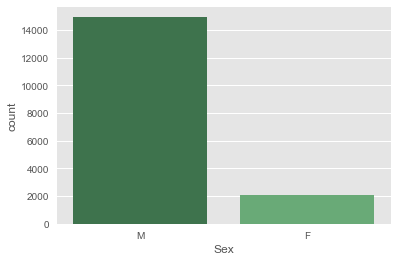

In [310]:
# dist by Gender
sns.countplot(x=df["Sex"], data=df['Recidivism'], palette="Greens_d");

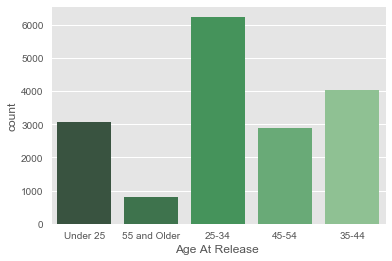

In [277]:
#dist by Age released
sns.countplot(x=df['Age At Release '],data=df['Recidivism'],palette='Greens_d');

In [312]:
cols_to_transform = df[['Race','Age At Release ','Convicting Offense Type']]

In [313]:
X = pd.get_dummies(cols_to_transform)
X.head()

,Race_Hispanic,Race_asian,Race_black,Race_other,Race_white,Age At Release _25-34,Age At Release _35-44,Age At Release _45-54,Age At Release _55 and Older,Age At Release _Under 25,Convicting Offense Type_Drug,Convicting Offense Type_Other,Convicting Offense Type_Property,Convicting Offense Type_Public Order,Convicting Offense Type_Violent
0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0


In [314]:
y = df['Recidivism'].values

# K-nn

In [287]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')

In [316]:
from sklearn.cross_validation import train_test_split

trainX, testX, trainY, testY = train_test_split(X, y, stratify=y, train_size=.50)
print trainX.shape, testX.shape
print trainY.shape, testY.shape

(8530, 15) (8530, 15)
(8530,) (8530,)


In [317]:
model= knn.fit(trainX,trainY)

In [318]:
y_predict = model.predict(testX)

In [319]:
model.score(testX,testY)

0.58229777256740911

In [320]:
#Confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

cnf_mtx = confusion_matrix(testY, y_predict)
print cnf_mtx

print classification_report(y_predict, testY)

[[4128 1700]
 [1863  839]]
             precision    recall  f1-score   support

          0       0.71      0.69      0.70      5991
          1       0.31      0.33      0.32      2539

avg / total       0.59      0.58      0.59      8530



Confusion matrix, without normalization
[[4128 1700]
 [1863  839]]


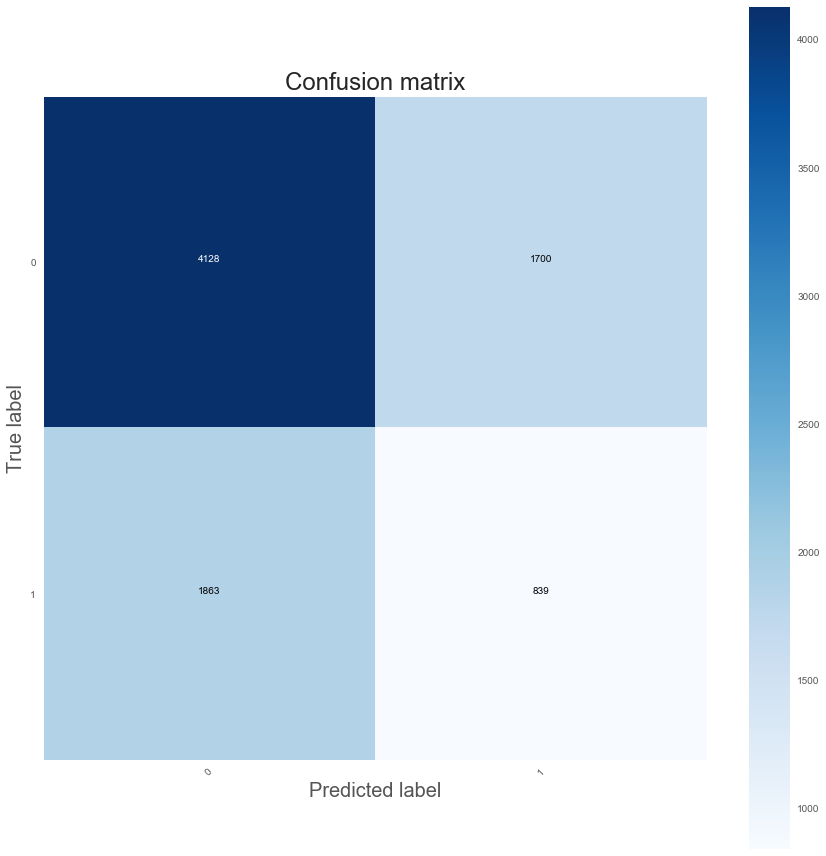

In [321]:
import itertools
from itertools import cycle

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca()
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=24)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.grid(b=False)
    ax.set_xticklabels([0,1,2,3])
    ax.set_yticklabels([0,1,2,3])
    plt.tight_layout()
    plt.ylabel('True label', size=20)
    plt.xlabel('Predicted label', size=20)

np.set_printoptions(precision=2)

class_names = df.Recidivism.unique()

plot_confusion_matrix(cnf_mtx, classes=class_names,
                      title='Confusion matrix')

plt.show()


# Start random forest model

In [54]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()


In [55]:
model.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [16]:
model = knn.fit(trainX, trainY)

ValueError: could not convert string to float: Discharged – End of Sentence